In [1]:
import numpy as np
import pandas as pd
import yfinance
import pandas_ta as ta

# Data
- Open
- High
- Low
- Close
- Volume
- PE
- PS
- EV_EBITDA
- Put Call Ratio

In [3]:
def get_yfdata(ticker, cols):
    yf_data = yfinance.download(ticker, end="2023-02-20")
    yf_data = yf_data.rename(columns={'Open':'open', 'High': 'high', 'Low':'low', 'Close':'close', 'Volume':'volume'})
    yf_data.drop(columns=['Adj Close'])
    print(ticker, yf_data.shape)
    return yf_data[cols]

In [4]:
ticker = 'AMZN'
df = get_yfdata('SPY', ['open', 'high', 'low', 'close','volume'])
close_cols = []
for col in close_cols:
    df = df.join(get_yfdata(col,'close').rename(col), how='outer')
df.head()

[*********************100%***********************]  1 of 1 completed
SPY (7569, 6)


open      high       low     close   volume
Date                                                       
1993-01-29  43.96875  43.96875  43.75000  43.93750  1003200
1993-02-01  43.96875  44.25000  43.96875  44.25000   480500
1993-02-02  44.21875  44.37500  44.12500  44.34375   201300
1993-02-03  44.40625  44.84375  44.37500  44.81250   529400
1993-02-04  44.96875  45.09375  44.46875  45.00000   531500

In [13]:
ratios = [('EV EBITDA Ratio','EV_EBITDA'),('PE Ratio', 'PE'),('PS Ratio', 'PS'),('Put Call Ratio', 'PutCall')]
for ratio in ratios:
    x = pd.read_csv(f'data/raw/{ticker} {ratio[0]}.csv', index_col=0)
    x = x.rename(columns={x.columns[0]: ratio[1]})
    x.index = pd.to_datetime(x.index)
    df = df.join(x, how='outer')
df.head()

open      high       low     close     volume  EV_EBITDA  PE  \
1993-01-29  43.96875  43.96875  43.75000  43.93750  1003200.0        NaN NaN   
1993-02-01  43.96875  44.25000  43.96875  44.25000   480500.0        NaN NaN   
1993-02-02  44.21875  44.37500  44.12500  44.34375   201300.0        NaN NaN   
1993-02-03  44.40625  44.84375  44.37500  44.81250   529400.0        NaN NaN   
1993-02-04  44.96875  45.09375  44.46875  45.00000   531500.0        NaN NaN   

            PS  PutCall  
1993-01-29 NaN      NaN  
1993-02-01 NaN      NaN  
1993-02-02 NaN      NaN  
1993-02-03 NaN      NaN  
1993-02-04 NaN      NaN

In [84]:
df.isna().sum()

open       8489
high       8489
low        8489
close      8489
volume     8489
^IRX        264
^TNX        763
^TYX       4533
CL=F      10409
GC=F      10419
CAD=X     11004
JPY=X      9238
EUR=X     11072
CNY=X     10670
dtype: int64

In [85]:
# preprocessing
df['!close_pct'] = df['close'].pct_change()
df['!open'] = df['open']
df['!close'] = df['close']
df['!high'] = df['high']
df['!low'] = df['low']
from scipy.stats.mstats import gmean
for col in df.columns:
    if '!' not in col:
        df[col] = df[col].pct_change()
        df[col] = df[col].apply(lambda x: x+1).rolling(window=5, min_periods=1).apply(gmean).apply(lambda x: x-1)
df = df.dropna()
print(df.shape)
df.head()

(4817, 19)


open      high       low     close    volume      ^IRX  \
Date                                                                     
2003-12-08 -0.000206 -0.000074 -0.000225 -0.000056 -0.034414 -0.001117   
2003-12-09  0.000967  0.000297 -0.000992 -0.001102  0.042814 -0.005513   
2003-12-10 -0.001640 -0.002044 -0.002082 -0.000804 -0.011325 -0.005544   
2003-12-11 -0.000916  0.000705 -0.000505  0.000613  0.046529 -0.006522   
2003-12-12  0.001582  0.000741  0.001440  0.002403  0.034442 -0.004055   

                ^TNX      ^TYX      CL=F      GC=F     CAD=X     JPY=X  \
Date                                                                     
2003-12-08 -0.005246 -0.001634  0.013962  0.001929 -0.001122 -0.003245   
2003-12-09 -0.001282  0.000815  0.006288  0.002220  0.001553 -0.003035   
2003-12-10 -0.004208 -0.001315  0.004966  0.001136  0.001411  0.000148   
2003-12-11 -0.006070 -0.001947  0.003747  0.000644  0.000746 -0.000536   
2003-12-12  0.001278  0.001619  0.014601  0.001472  0.001622  0.000111   

               EUR=X     CNY=X  !close_pct       !open      !close  \
Date                                                                 
2003-12-08 -0.004209 -0.000002    0.006738  106.739998  107.570000   
2003-12-09 -0.002642 -0.000002   -0.007716  107.900002  106.739998   
2003-12-10 -0.001118 -0.000002   -0.000094  106.769997  106.730003   
2003-12-11 -0.002352  0.000002    0.011243  106.680000  107.930000   
2003-12-12 -0.001504  0.000005    0.001946  107.970001  108.139999   

                 !high        !low  
Date                                
2003-12-08  107.639999  106.680000  
2003-12-09  107.930000  106.540001  
2003-12-10  106.980003  105.959999  
2003-12-11  108.099998  106.669998  
2003-12-12  108.199997  107.389999

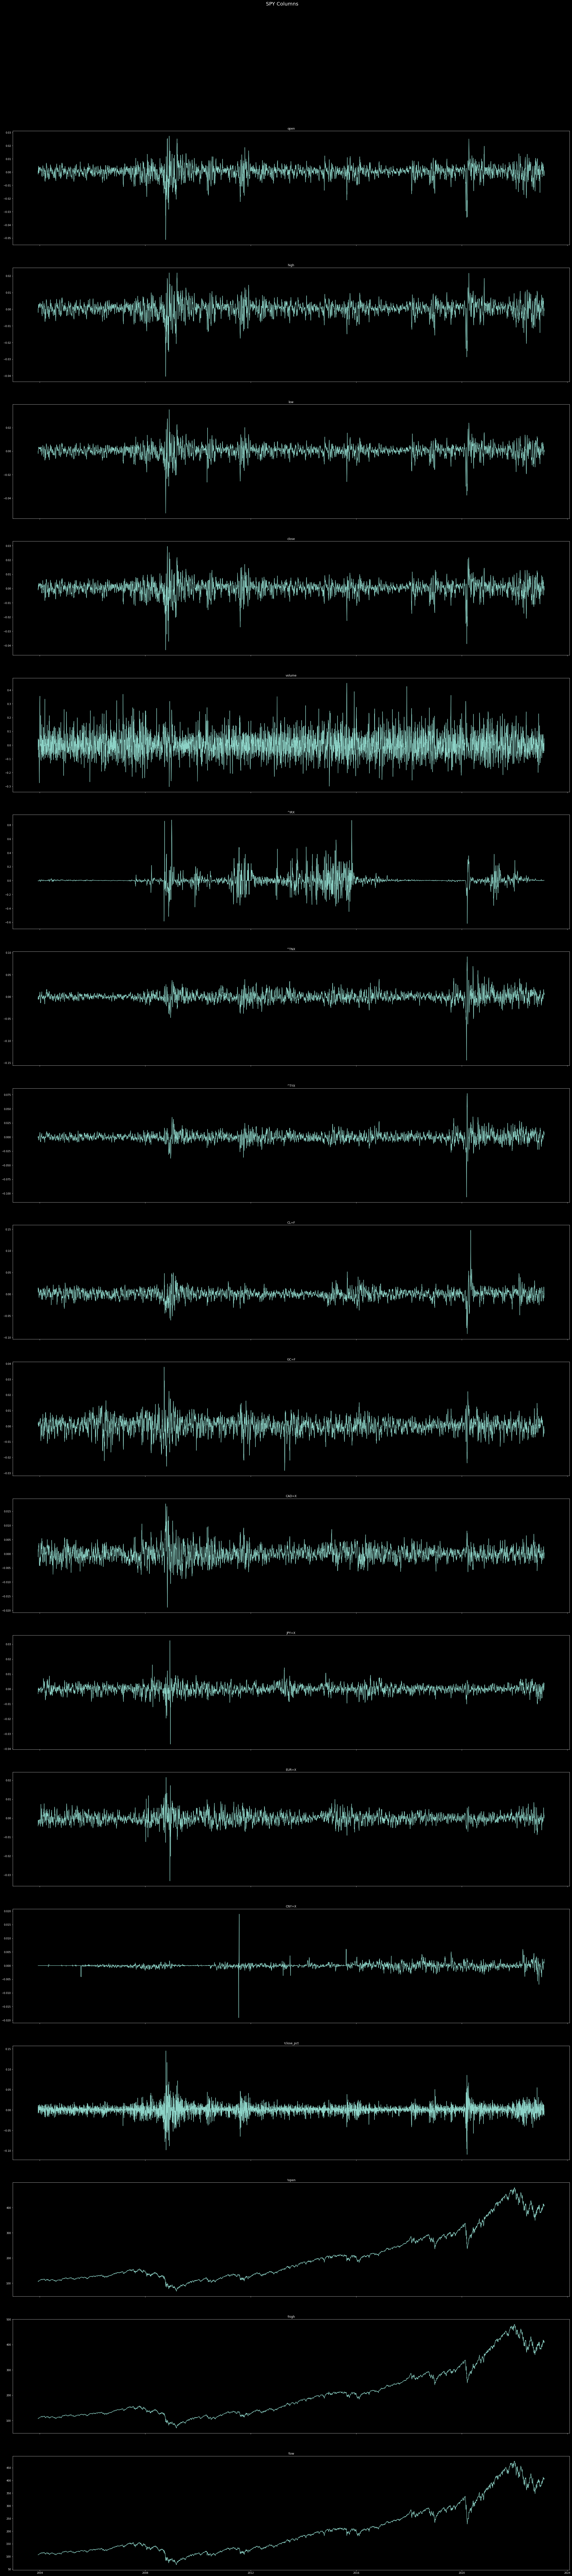

In [69]:
from utils.plot_utils import *
plot_cols(df, ticker)

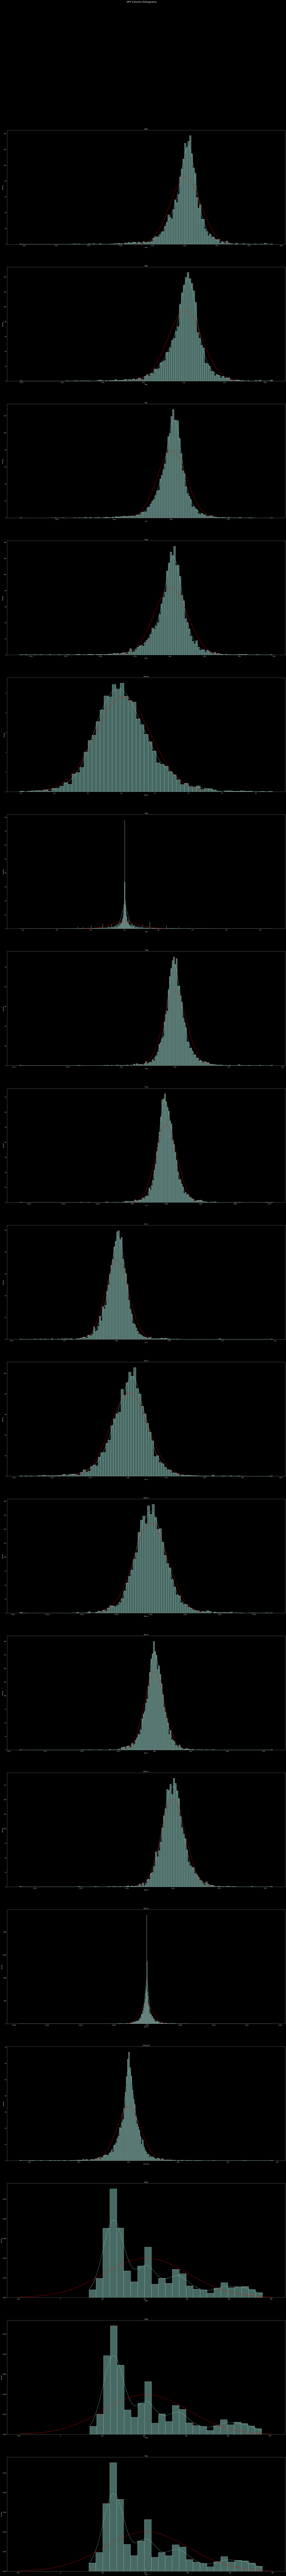

In [70]:
plot_col_histogram(df, ticker)

In [86]:
df_train = df.iloc[:int(0.8*df.shape[0]),:]
df_val = df.iloc[int(0.8*df.shape[0]):int(0.9*df.shape[0]),:]
df_test = df.iloc[int(0.9*df.shape[0]):,:]
df_train.shape

(3853, 19)

In [87]:
def get_outliers(df, gaus_cols, iqr_mult = 1.5, replace = False):
    df = df.copy()
    outlier = df.iloc[:,0].apply(lambda x: False)
    print(df.shape)
    for col in df.columns:
        if col in gaus_cols:
            q1, q3 = np.percentile(df[col],[25,75])
            upper_bound = q3 + iqr_mult*(q3-q1)
            lower_bound = q1 - iqr_mult*(q3-q1)

            high_out = df[col] > upper_bound
            low_out = df[col] < lower_bound
            col_out = high_out | low_out
            print(f'{col}: {(lower_bound, upper_bound)} High Outliers = {high_out.sum()}, Low Outliers = {low_out.sum()}, Total Outliers = {col_out.sum()}')

            if replace:
                df[col] = np.where(high_out, upper_bound, df[col])
                df[col] = np.where(low_out, lower_bound, df[col])
            
            outlier |= col_out
    print(f'Total Outliers: {outlier.sum()}')
    print(df[~outlier].shape)
    return df, outlier

In [88]:
X_cols = [col for col in df.columns if '!' not in col and col!='^IRX']
df_train_fixed, outliers = get_outliers(df_train, X_cols, iqr_mult=3, replace=True)

(3853, 19)
open: (-0.014089855030084975, 0.015026600098786647) High Outliers = 12, Low Outliers = 41, Total Outliers = 53
high: (-0.013005351197356907, 0.013902151898069093) High Outliers = 10, Low Outliers = 33, Total Outliers = 43
low: (-0.015102719751196592, 0.016028379098916523) High Outliers = 12, Low Outliers = 44, Total Outliers = 56
close: (-0.014509648768868066, 0.015444262939422249) High Outliers = 12, Low Outliers = 32, Total Outliers = 44
volume: (-0.3534242651867643, 0.35574657116976816) High Outliers = 7, Low Outliers = 0, Total Outliers = 7
^TNX: (-0.03331663836414811, 0.03292739933664868) High Outliers = 9, Low Outliers = 10, Total Outliers = 19
^TYX: (-0.025323534197202457, 0.02507073797705517) High Outliers = 9, Low Outliers = 12, Total Outliers = 21
CL=F: (-0.039320658254984764, 0.03987130557108498) High Outliers = 11, Low Outliers = 8, Total Outliers = 19
GC=F: (-0.02048077273631277, 0.021222629940581994) High Outliers = 6, Low Outliers = 11, Total Outliers = 17
CAD

In [89]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
def standardize_and_scale(df_train, df_train_fixed, df_val, df_test, outliers):
    scalers = {}
    df_train_norm = pd.DataFrame()
    df_val_norm = pd.DataFrame()
    df_test_norm = pd.DataFrame()
    for i, col in enumerate(df_train.columns):
        
        if 'Y_' not in col and '!' not in col:
            scaler = RobustScaler()
            scaler = scaler.fit(np.array(df_train[~outliers][col]).reshape(-1,1))
            df_train_norm[col] = pd.Series(np.squeeze(scaler.transform(np.array(df_train_fixed[col]).reshape(-1,1))), index=df_train.index)
            df_val_norm[col] = pd.Series(np.squeeze(scaler.transform(np.array(df_val[col]).reshape(-1,1))), index=df_val.index)
            df_test_norm[col] = pd.Series(np.squeeze(scaler.transform(np.array(df_test[col]).reshape(-1,1))), index=df_test.index)
            scalers[col] = scaler
    
        else:
            df_train_norm[col] = df_train[col]
            df_val_norm[col] = df_val[col]
            df_test_norm[col] = df_test[col]

    print(scalers)
    return df_train_norm, df_val_norm, df_test_norm, scalers

In [90]:
df_train_norm, df_val_norm, df_test_norm, scalers = standardize_and_scale(df_train, df_train, df_val, df_test, outliers)
df_train_norm.head()

{'open': RobustScaler(), 'high': RobustScaler(), 'low': RobustScaler(), 'close': RobustScaler(), 'volume': RobustScaler(), '^IRX': RobustScaler(), '^TNX': RobustScaler(), '^TYX': RobustScaler(), 'CL=F': RobustScaler(), 'GC=F': RobustScaler(), 'CAD=X': RobustScaler(), 'JPY=X': RobustScaler(), 'EUR=X': RobustScaler(), 'CNY=X': RobustScaler()}


open      high       low     close    volume      ^IRX  \
Date                                                                     
2003-12-08 -0.205297 -0.204256 -0.195143 -0.171192 -0.330681 -0.104028   
2003-12-09  0.086133 -0.103272 -0.373983 -0.424764  0.454007 -0.349668   
2003-12-10 -0.561763 -0.740264 -0.628110 -0.352524 -0.096077 -0.351376   
2003-12-11 -0.381781  0.007703 -0.260569 -0.009171  0.491754 -0.406042   
2003-12-12  0.239058  0.017628  0.193020  0.424823  0.368947 -0.268197   

                ^TNX      ^TYX      CL=F      GC=F     CAD=X     JPY=X  \
Date                                                                     
2003-12-08 -0.530363 -0.188686  1.204533  0.240150 -0.346191 -1.083952   
2003-12-09 -0.102279  0.159155  0.509038  0.290275  0.534761 -1.015571   
2003-12-10 -0.418226 -0.143378  0.389249  0.103078  0.488061  0.019377   
2003-12-11 -0.619347 -0.233126  0.278687  0.017971  0.269028 -0.203027   
2003-12-12  0.174135  0.273481  1.262503  0.161097  0.557416  0.007602   

               EUR=X     CNY=X  !close_pct       !open      !close  \
Date                                                                 
2003-12-08 -1.328625  0.006260    0.006738  106.739998  107.570000   
2003-12-09 -0.828517  0.006260   -0.007716  107.900002  106.739998   
2003-12-10 -0.341932  0.006321   -0.000094  106.769997  106.730003   
2003-12-11 -0.736029  0.018961    0.011243  106.680000  107.930000   
2003-12-12 -0.465059  0.025281    0.001946  107.970001  108.139999   

                 !high        !low  
Date                                
2003-12-08  107.639999  106.680000  
2003-12-09  107.930000  106.540001  
2003-12-10  106.980003  105.959999  
2003-12-11  108.099998  106.669998  
2003-12-12  108.199997  107.389999

(3853, 19)
(3853, 14) Index(['open', 'high', 'low', 'close', 'volume', '^IRX', '^TNX', '^TYX',
       'CL=F', 'GC=F', 'CAD=X', 'JPY=X', 'EUR=X', 'CNY=X'],
      dtype='object')
(3853, 14)
[0.59957425 0.14181813 0.11521429 0.04075761 0.02949484 0.01667993
 0.01579579 0.01337475 0.01067095 0.00819028 0.00501146 0.00148726
 0.0012332  0.00069726]


<BarContainer object of 14 artists>

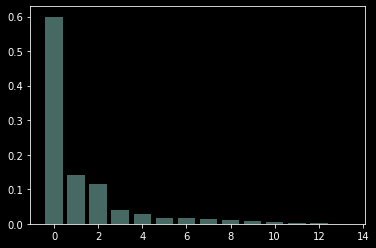

In [91]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

PCA_col = [col for col in df.columns if '!' not in col and 'Y_' not in col]
PCA_df = df_train_norm[PCA_col]
print(df_train_norm.shape)
print(PCA_df.shape, PCA_df.columns)

n_components = len(PCA_col)
pca = PCA(n_components=n_components).fit(PCA_df)
PCA_df = pca.transform(PCA_df)
print(PCA_df.shape)
print(pca.explained_variance_ratio_)
plt.bar(range(0,len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')

In [92]:
for c in range(n_components):
    df_train_norm[f'pca_{c}'] = pca.transform(df_train_norm[PCA_col])[:,c]
    df_val_norm[f'pca_{c}'] = pca.transform(df_val_norm[PCA_col])[:,c]
    df_test_norm[f'pca_{c}'] = pca.transform(df_test_norm[PCA_col])[:,c]
df_train_norm.tail()

open      high       low     close    volume      ^IRX  \
Date                                                                     
2019-03-25 -0.629044 -0.661331 -0.752545 -0.725265  0.688464 -0.018178   
2019-03-26 -0.597494 -0.602591 -0.450055 -0.377814 -0.537113 -0.041590   
2019-03-27 -0.339351 -0.518918 -0.541618 -0.485723 -0.297583 -0.181530   
2019-03-28 -0.205491 -0.946001 -0.395852 -0.846052 -0.661852 -0.219086   
2019-03-29 -0.299939 -0.368398  0.183690  0.400508 -0.762984 -0.371717   

                ^TNX      ^TYX      CL=F      GC=F  ...     pca_4     pca_5  \
Date                                                ...                       
2019-03-25 -1.518650 -1.342134 -0.143860  0.477086  ... -0.497714  0.262096   
2019-03-26 -1.669331 -1.500448  0.216850  0.152320  ... -0.810574 -0.788224   
2019-03-27 -1.371769 -1.458747 -0.188489  0.155809  ... -1.030455 -0.488683   
2019-03-28 -1.254255 -1.454442 -0.267325 -0.526829  ... -1.376995 -0.814179   
2019-03-29 -0.326983 -0.621691  0.274355 -0.586267  ... -0.653943 -0.940671   

               pca_6     pca_7     pca_8     pca_9    pca_10    pca_11  \
Date                                                                     
2019-03-25 -0.258867 -0.517043  0.125008  0.207002  0.055457  0.058221   
2019-03-26 -0.618443 -0.327150 -0.470277  0.162422  0.127800  0.005894   
2019-03-27 -0.543871 -0.274134 -0.042122 -0.020491 -0.057272 -0.165969   
2019-03-28 -0.714812 -0.312567 -0.294745 -0.115618 -0.477412  0.051240   
2019-03-29 -0.425069 -0.482301 -0.475093 -0.010587  0.437502  0.024250   

              pca_12    pca_13  
Date                            
2019-03-25  0.031258 -0.020619  
2019-03-26  0.101160 -0.016875  
2019-03-27  0.024856 -0.101198  
2019-03-28 -0.166867 -0.186444  
2019-03-29 -0.258072 -0.119140  

[5 rows x 33 columns]

In [93]:
df_train_norm['Y_reg'] = df_train_norm['close'].shift(-1)
df_train_norm.loc[df_train_norm.index[-1], 'Y_reg'] = df_val_norm.loc[df_val_norm.index[0], 'close']

df_val_norm['Y_reg'] = df_val_norm['close'].shift(-1)
df_val_norm.loc[df_val_norm.index[-1], 'Y_reg'] = df_test_norm.loc[df_test_norm.index[0], 'close']

df_test_norm['Y_reg'] = df_test_norm['close'].shift(-1)
df_test_norm.dropna(inplace=True)

In [94]:
df_test_norm.isna().sum()

open          0
high          0
low           0
close         0
volume        0
^IRX          0
^TNX          0
^TYX          0
CL=F          0
GC=F          0
CAD=X         0
JPY=X         0
EUR=X         0
CNY=X         0
!close_pct    0
!open         0
!close        0
!high         0
!low          0
pca_0         0
pca_1         0
pca_2         0
pca_3         0
pca_4         0
pca_5         0
pca_6         0
pca_7         0
pca_8         0
pca_9         0
pca_10        0
pca_11        0
pca_12        0
pca_13        0
Y_reg         0
dtype: int64

In [82]:
import pickle

df_train_norm.to_csv('data/processed/macro/macro_train.csv')
df_val_norm.to_csv('data/processed/macro/macro_val.csv')
df_test_norm.to_csv('data/processed/macro/macro_test.csv')
with open('data/processed/macro/scalers.pickle', mode='wb',) as f: pickle.dump(scalers, f, protocol=pickle.HIGHEST_PROTOCOL)